# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "torch"

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Rescaling, Dropout, Resizing
from keras.layers import RandomFlip, RandomTranslation, RandomRotation, RandomZoom
from keras.models import Sequential
from keras.metrics import F1Score, Precision, AUC
from keras.losses import CategoricalFocalCrossentropy, BinaryFocalCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.utils import compute_class_weight
from keras.utils import to_categorical

from PIL import Image

# Move images into class folders

In [ ]:
def move_and_separate_images(list_of_folders, df_metadata):
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0
    for folder in list_of_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                try:
                    os.makedirs(f"dataset/{df_metadata.loc[file.strip('.jpg'), 'dx']}")
                except:
                    source=os.path.join(root, file)
                    destination=os.path.join('dataset', df_metadata.loc[file.strip('.jpg'), 'dx'], file)
                    os.rename(source,destination)
                    count += 1
                    if count%100 == 0:
                        print(f'{count} images were processed')

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

move_and_separate_images(['HAM10000_images_part_1', 'HAM10000_images_part_2'], df)

# Move images into cancerous/non cancerous folders

In [ ]:
class_mapping = {
    "akiec": "canc",
    "bcc": "canc",
    "bkl": "nocanc",
    "df": "nocanc",
    "mel": "canc",
    "nv": "nocanc",
    "vasc": "nocanc"
}

In [ ]:
def move_and_separate_images(list_of_folders, df_metadata):
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0
    for folder in list_of_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                try:
                    os.makedirs(f"dataset/{class_mapping[df_metadata.loc[file.strip('.jpg'), 'dx']]}")
                except:
                    source=os.path.join(root, file)
                    destination=os.path.join('dataset', class_mapping[df_metadata.loc[file.strip('.jpg'), 'dx']], file)
                    os.rename(source,destination)
                    count += 1
                    if count%100 == 0:
                        print(f'{count} images were processed')

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

move_and_separate_images(['HAM10000_images_part_1', 'HAM10000_images_part_2'], df)

# Make arrays

In [2]:
def array_from_images(folder, df_metadata, dict_of_labels, h=224, w=224, channels=3):
    # Create an array of images and labels the size of the number of pictures
    nb_files = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            nb_files += 1
    array = np.zeros(shape=(nb_files, h, w, channels))
    labels = np.zeros(shape=(nb_files,))

    # Check the name and fill array and labels
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0

    for root, dirs, files in os.walk(folder):
        for file in files:
            with Image.open(os.path.join(root, file)) as im:
                array[count,:,:,:] = np.asarray(im.resize((h,w)))
                try:
                    labels[count] = dict_of_labels[class_mapping[df_metadata.loc[file.strip('.jpg'), 'dx']]]
                except:
                    labels[count] = dict_of_labels[df_metadata.loc[file.strip('.jpg'), 'dx']]
                count += 1
                if count%100 == 0:
                    print(f'{count} images were processed')
    return array, labels

In [3]:
class_mapping = {
    "akiec": "canc",
    "bcc": "canc",
    "bkl": "nocanc",
    "df": "nocanc",
    "mel": "canc",
    "nv": "nocanc",
    "vasc": "nocanc"
}

In [5]:
df = pd.read_csv('HAM10000_metadata.csv')
dict_label = {k:v for k,v in zip(['nocanc', 'canc'], range(2))}
# dict_label = {k:v for k,v in zip(list(class_mapping.keys()), range(7))}
size = 128

X, y = array_from_images('dataset/', df, dict_label, h=size, w=size)


100 images were processed
200 images were processed
300 images were processed
400 images were processed
500 images were processed
600 images were processed
700 images were processed
800 images were processed
900 images were processed
1000 images were processed
1100 images were processed
1200 images were processed
1300 images were processed
1400 images were processed
1500 images were processed
1600 images were processed
1700 images were processed
1800 images were processed
1900 images were processed
2000 images were processed
2100 images were processed
2200 images were processed
2300 images were processed
2400 images were processed
2500 images were processed
2600 images were processed
2700 images were processed
2800 images were processed
2900 images were processed
3000 images were processed
3100 images were processed
3200 images were processed
3300 images were processed
3400 images were processed
3500 images were processed
3600 images were processed
3700 images were processed
3800 image

In [ ]:
np.savez_compressed(f'X-{size}x{size}', X, allow_pickle=True)
np.savez_compressed(f'y-{size}x{size}', y, allow_pickle=True)

# Load arrays

In [ ]:
size = 128
X = np.load(f'X-{size}x{size}.npz')['arr_0']
y = np.load(f'y-{size}x{size}.npz')['arr_0']

# Split arrays

In [6]:
from sklearn.model_selection import train_test_split

X_train, X, y_train, y = train_test_split(X, y, stratify=y, test_size=0.2, random_state=38)



X_test, X_val, y_test, y_val = train_test_split(X, y, stratify=y, test_size=0.5, random_state=38)

del X, y

# SMOTETOMEK

In [ ]:
shape_origin = X_train.shape

X_train = np.reshape(X_train, (shape_origin[0], shape_origin[1]*shape_origin[2]*shape_origin[3]))

smotetomek = SMOTETomek(random_state=38, n_jobs=-1)

X_train, y_train = smotetomek.fit_resample(X_train, y_train)

X_train = np.reshape(X_train, (X_train.shape[0], shape_origin[1], shape_origin[2], shape_origin[3]))



# One Hot Encoding of labels

In [7]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Helper functions

In [8]:
def get_earlystopping(patience=10):
    early_stopping = EarlyStopping(
    monitor='val_average_precision',
    patience=patience,
    verbose=1,
    restore_best_weights=True)
    return early_stopping

In [9]:
def plot_learning_curves(model):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].plot(model.history.history['val_f1_score'], label='val_f1_score')
    ax[0].plot(model.history.history['f1_score'], label='f1_score')
    ax[0].legend()
    try:
        ax[1].plot(model.history.history['val_average_precision'], label='val_avg_prec')
        ax[1].plot(model.history.history['average_precision'], label='avg_prec')
        ax[1].legend()
    except:
        pass
    #     ax[1].plot(model.history.history['val_precision_1'], label='val_precision_1')
    #     ax[1].plot(model.history.history['precision_1'], label='precision_1')
    #     ax[1].legend()
    ax[2].plot(model.history.history['val_loss'], label='val_loss')
    ax[2].plot(model.history.history['loss'], label='loss')
    ax[2].legend()
    fig.show;

In [10]:
def get_analysis(model, testX, testy):
    plot_learning_curves(model)
    loss, f1, avg_prec = model.evaluate(testX, testy)
    print(f'The model gave')
    print(f'Loss: {loss:.2f}')
    print(f'F1 Macro: {f1:.2f}')
    print(f'Avg Prec: {avg_prec:.2f}')
    y_pred = model.predict(testX)
    y_res = np.argmax(y_pred, axis=1)
    print(classification_report(testy, y_res))
    return y_pred, y_res

In [11]:
def get_analysis_cat(model, testX, testy):
    plot_learning_curves(model)
    loss, f1, avg_prec = model.evaluate(testX, testy)
    print(f'The model gave')
    print(f'Loss: {loss:.2f}')
    print(f'F1 Macro: {f1:.2f}')
    print(f'Avg Prec: {avg_prec:.2f}')
    predy = model.predict(testX)
    resy = to_categorical(np.argmax(predy, axis=1))
    print(classification_report(testy,resy))
    return predy, resy

In [12]:
def compile_and_train(model, loss, opt, metrics, epochs, patience=None, steps=None):
    model.compile(loss=loss,
                optimizer=opt,
                metrics=metrics)

    model.summary()

    if patience != None:
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[get_earlystopping(patience)],
            steps_per_epoch=steps
            )
    else:
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            steps_per_epoch=steps
            )

    return model

# Model

In [ ]:
filters = 16

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1:])),
    Rescaling(1./255),
    RandomFlip(),
    RandomRotation(factor=(-0.3, 0.3)),
    RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3, 0.3)),
    RandomZoom(height_factor=(-0.3,0.3), width_factor=(-0.3, 0.3)),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters*8, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*8, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*8, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(filters, activation='relu'),
    Dense(2, activation='softmax')
])



In [13]:
from keras.applications import VGG16

vgg16 = VGG16(
    include_top=False,
    input_shape=(128,128, 3),
    classes=2,
    classifier_activation="softmax",
    name="vgg16",
)

In [16]:
model = Sequential([
    Input(shape=(X_train.shape[1:])),
    vgg16, 
    Dropout(0.2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

In [17]:
history020 = compile_and_train(model,
                               loss=BinaryFocalCrossentropy(apply_class_balancing=True),
                               opt='adamw',
                               metrics=[F1Score(average='macro'), AUC(curve="PR", name="average_precision")],
                               epochs=500,
                               patience=50)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │       131,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,845,810 (56.63 MB)

 Trainable params: 14,845,810 (56.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - average_precision: 0.7681 - f1_score: 0.4464 - loss: 1.5595 - val_average_precision: 0.7687 - val_f1_score: 0.4460 - val_loss: 1.5571
Epoch 2/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - average_precision: 0.7685 - f1_score: 0.4460 - loss: 1.5585 - val_average_precision: 0.7687 - val_f1_score: 0.4460 - val_loss: 1.5571
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - average_precision: 0.7685 - f1_score: 0.4460 - loss: 1.5585 - val_average_precision: 0.7687 - val_f1_score: 0.4460 - val_loss: 1.5571
Epoch 4/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - average_precision: 0.7685 - f1_score: 0.4460 - loss: 1.5585 - val_average_precision: 0.7687 - val_f1_score: 0.4460 - val_loss: 1.5571
Epoch 5/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - average_precision: 0.7685 - f1_score: 0.4460 - loss: 1.5585 - val_average_precision: 0.7687 - val_f1_score: 0.4460 - val_loss: 1.5571
Epoch 6/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - average_precision: 0.7687 - f1_score: 0.4460 - loss: 1.5571
The model gave
Loss: 1.56
F1 Macro: 0.45
Avg Prec: 0.77
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

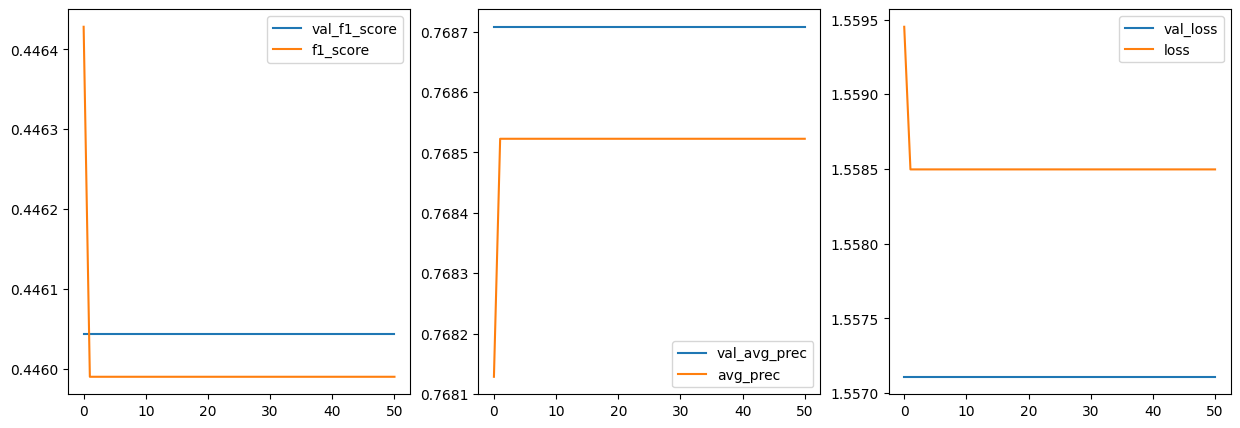

In [18]:
get_analysis_cat(model, X_test, y_test)

In [ ]:
torch.save(model, "model_avgprec_94.pth")

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


## Custom loss

In [ ]:
import tensorflow as tf
from keras.losses import CategoricalFocalCrossentropy
from keras import backend as K
from keras import ops

def f1macro(y_true, y_pred):
    tp = []
    fp = []
    fn = []
    precision = []
    recall = []
    f1 = []

    cfc = CategoricalFocalCrossentropy()


    for n in range(7):
        tp.append(ops.sum(ops.cast(y_true[:, n] * y_pred[:, n], 'float32'), axis=0))
        fp.append(ops.sum(ops.cast((1 - y_true[:, n]) * y_pred[:, n], 'float32'), axis=0))
        fn.append(ops.sum(ops.cast(y_true[:, n] * (1 - y_pred[:, n]), 'float32'), axis=0))

    for n in range(7):
        precision.append(tp[n] / (tp[n] + fp[n] + K.epsilon()))
        recall.append(tp[n] / (tp[n] + fn[n] + K.epsilon()))

    for n in range(7):
        f1.append(2 * (precision[n] * recall[n]) / (precision[n] + recall[n] + K.epsilon()))

    f1macro = tf.stack(f1)
    f1macroscore = ops.mean(f1macro)

    f1macroscore = tf.where(tf.math.is_nan(f1macroscore), tf.zeros_like(f1macroscore), f1macroscore)

    return cfc + (1 - f1macroscore)